# Data Acquisition 

### You must load the required packages for this to work. If you do not have any of the packages listed, please use the function install.packages('< packagename>') to install them directly from CRAN.
#### You may also cut and copy this code into you R console and it will automatically install the packages you do not have.
> install.packages(c('httr', 'lubridate', 'jsonlite', 'plyr', 'ggplot2', 'tidyr'))

In [1]:
library(httr)
library(lubridate)
library(jsonlite)
library(plyr)
library(ggplot2)
library(tidyr)
options(stringsAsFactors = F)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘plyr’

The following object is masked from ‘package:lubridate’:

    here



### This step creates a vector of the endpoints needed for each API call and the corresponding names for each output. 

In [2]:
'pageviews_mobile-web_201507-201709' <- 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-web/user/monthly/2015070100/2017093000'
'pageviews_mobile-app_201507-201709' <- 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/mobile-app/user/monthly/2015070100/2017093000'
'pageviews_desktop_201507-201709' <- 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2015070100/2017093000'
'pagecounts_desktop-site_200801-201607' <- 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2008010100/2016073100'
'pagecounts_mobile-site_200801-201607' <- 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/mobile-site/monthly/2008010100/2016073100' 

# create endpoints and names vectors
endpoints <- c(`pageviews_mobile-web_201507-201709`, `pageviews_mobile-app_201507-201709`,
             `pageviews_desktop_201507-201709`, `pagecounts_desktop-site_200801-201607`,
             `pagecounts_mobile-site_200801-201607`)

names <- c('pageviews_mobile-web_201507-201709', 'pageviews_mobile-app_201507-201709',
           'pageviews_desktop_201507-201709', 'pagecounts_desktop-site_200801-201607',
           'pagecounts_mobile-site_200801-201607')

### I created a function to streamline the process of scraping the data from each API listed above. This function takes as input the endpoint URL and outputs the parsed json data of interest. 

In [3]:
get.data <- function(endpoint){
    # function to get, parse and save the json of each api call
    # endpoint is the URL for the API
    name <- deparse(substitute(endpoint))
    raw.data <- GET(endpoint)
    raw.content <- rawToChar(raw.data$content)
    parsed.data <- fromJSON(raw.content)
    # save all the json files with the names from the above vector
    write(toJSON(parsed.data), paste0(name,'.json'))
    parsed.data
}

### Next I recursively call the above function and load the function output, the parsed data, into a list.

In [4]:
# init empty list for parsed data
parsed.data <- list()
for (i in 1:length(endpoints)){
    parsed.data[[i]] <- get.data(endpoints[i])
    names(parsed.data[[i]]) <- names[i]
}

# Data Processing
### Now that the data has been acquired from the web via the APIs above, we need to process it in a form that is usable for analysis. 
### The following code loops through the parsed data and extracts the needed information. This is loaded into a list and then using the ldply function from the plyr package, collapses the list into a dataframe. Don't you just love R? 

In [5]:
# init an empty list for the total data
tot.list <- list()
# loop through the API results extracting the time and the counts from each
for(i in 1:length(parsed.data)){
    time <- c()
    count <- c()
    time <- parsed.data[[i]][[1]][[5]]
    # because the two apis have different numbers of arguments the index is different for pagecounts vs pageviews
    if(i <= 3){
        count <- parsed.data[[i]][[1]][[6]]
        time <- parsed.data[[i]][[1]][[5]]
    }
    else {
        count <- parsed.data[[i]][[1]][[5]]
        time <- parsed.data[[i]][[1]][[4]]
    }
    temp.data <- data.frame('time' = time,
                            'views' = count,
                            'type' = as.character(names(parsed.data[[i]])))
    tot.list[[i]] <- temp.data
}
# collapse the list into a dataframe
total.data <- ldply(tot.list, data.frame)

### The data is currently in long form and in order to compute the total mobile from mobile-web and mobile-app as well as compute the total page views for each, the wide form of the data is preferable. 

In [6]:
# convert data from long to wide form
wide.data <- spread(total.data, type, views)

# convert NA values to 0 in each column
wide.data <- data.frame(apply(wide.data, 2, function(x) ifelse(is.na(x), as.numeric(0), as.numeric(x))))
# change the schema to match what is needed
names(wide.data) <- c('time', 'pagecount_desktop_views','pagecount_mobile_views', 
                      'pageview_desktop_views', 'pageview_mobile.app_views',
                      'pageview_mobile.web_views')
wide.data$pagecount_all_views <- wide.data$pagecount_desktop_views + wide.data$pagecount_mobile_views
wide.data$pageview_mobile_views <- wide.data$pageview_mobile.app_views + wide.data$pageview_mobile.web_views
wide.data$pageview_all_views <- wide.data$pageview_mobile_views + wide.data$pageview_desktop_views
wide.data <- wide.data[,-c(5,6)]

### Next I needed to parse the time into a datetime format in R, then extract the year and the month in order to follow the schema that was assigned. 

In [7]:
wide.data$time <- as.Date(as.character(wide.data$time), format = '%Y%m%d')
wide.data$year <- year(wide.data$time)
wide.data$month <- month(wide.data$time)
# reorder columns
wide.data.forsave <- wide.data[c(8,9,5,2,3,7,4,6)]
write.csv(wide.data.forsave, file = 'en-wikipedia_traffic_200801-201709.csv', row.names = F)

### The final step was to create a tidy dataframe and plot using ggplot.

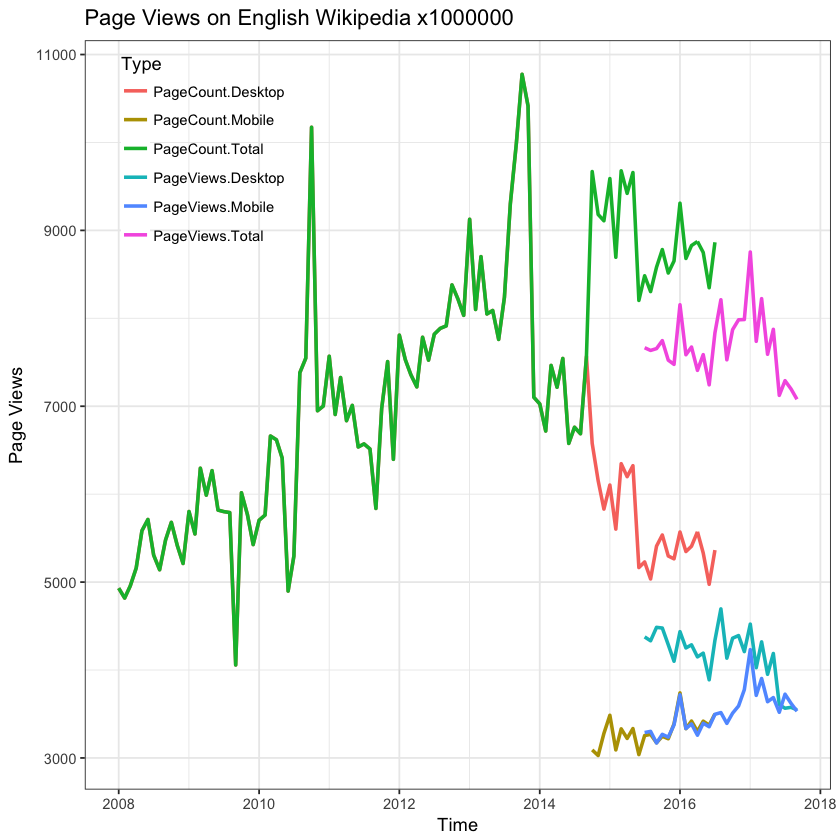

In [11]:
wide.data.forplot <- wide.data[c(5,2,3,7,4,6,1)]
names(wide.data.forplot) <- c('PageCount.Total', 'PageCount.Desktop', 'PageCount.Mobile',
                             'PageViews.Total', 'PageViews.Desktop', 'PageViews.Mobile', 'time')
wide.data.forplot[,1:6] <- wide.data.forplot[,1:6] / 1000000
tidy.data <- gather(wide.data.forplot, Type, value, 1:6)
tidy.data$value <- sapply(tidy.data$value, function(x) ifelse((x == 0), NA, x))
idx.total <- grep('all', tidy.data$Type)
idx.main <- grep('desktop', tidy.data$Type)
idx.mobile <- grep('mobile', tidy.data$Type)

plot <- ggplot(na.omit(tidy.data), aes(time, value)) +
    geom_line(aes(color = Type), size = 1) +
    # geom_line(aes(color = key2)) +
    xlab('Time') +
    ylab('Page Views') +
    ggtitle('Page Views on English Wikipedia x1000000') +
    theme_bw() +
    theme(legend.position = c(0.16,.85),
          legend.background = element_blank()) +
    guides(fill=guide_legend(title='Site Type'))

plot